In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import seaborn as sns
from tqdm.auto import tqdm

In [151]:
df_dev = pd.read_csv('data/development.csv').set_index('Id')
df_eval = pd.read_csv('data/evaluation.csv').set_index('Id')

# We drop the sampling rate, which is the same value for all samples
# We drop the path, which is not useful for the regression task
df_dev.drop(['sampling_rate', 'path'], axis=1, inplace=True)
df_eval.drop(['sampling_rate', 'path'], axis=1, inplace=True)

# We convert the tempo to the float data type from the format '[float]'
df_dev['tempo'] = df_dev['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype('float')
df_eval['tempo'] = df_eval['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype('float')

df_dev.head()

,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,,
0,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,281,39,23.846893
1,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,281,21,19.388662
2,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,281,1,21.640998
3,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,281,9,19.644127
4,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,281,11,18.041905


Plot age distribution

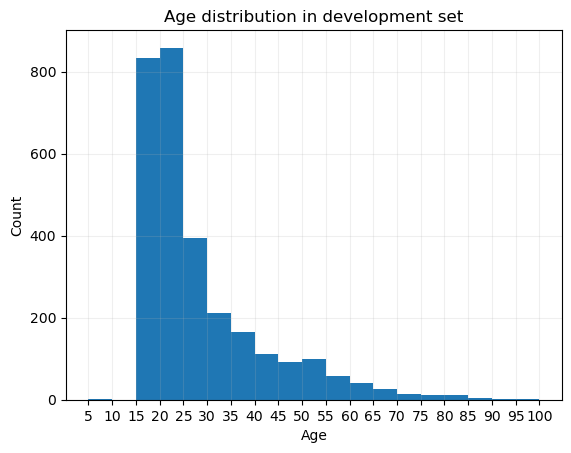

In [152]:
fig, ax = plt.subplots()
ax.hist(df_dev["age"], bins=range(5,int((max(df_dev["age"])+5)),5), label="Development")
ax.set_xticks(range(5,int((max(df_dev["age"])+5)),5))
ax.set_title("Age distribution in development set")
ax.set_xlabel("Age")
ax.set_ylabel("Count")
ax.grid(alpha=0.2)

Ethnicity distribution

In [153]:
# Ethnicities in development set
set1 = set(df_dev["ethnicity"])
set2 = set(df_eval["ethnicity"])
set1.intersection(set2)
print(f"Number of ethnicities in development set: {len(set1)}")
print(f"Number of ethnicities in evaluation set: {len(set2)}")
print(f"Number of ethnicities in both sets: {len(set1.intersection(set2))}")
print(set1.intersection(set2))

Number of ethnicities in development set: 165
Number of ethnicities in evaluation set: 73
Number of ethnicities in both sets: 17
{'annang', 'indian', 'igbo', 'nigerian', 'ikwerre', 'congolese', 'kanuri', 'satawalese', 'ibibio', 'afemai', 'cameroonian', 'ukwani', 'yoruba', 'urhobo', 'ijaw', 'igala', 'hausa'}


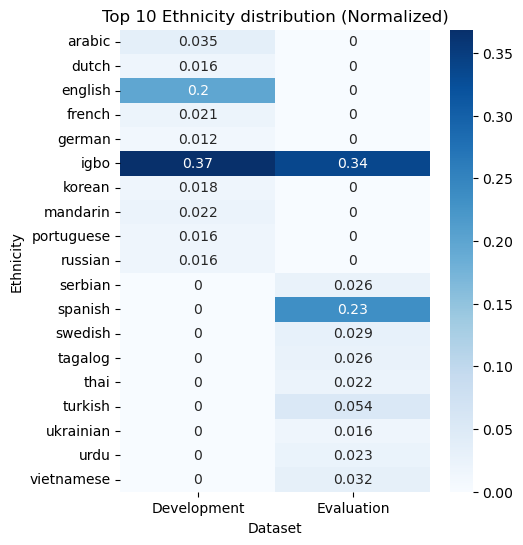

In [170]:

# Combine the counts into a single DataFrame
ethnicity_counts = pd.DataFrame({
    'Development': df_dev['ethnicity'].value_counts(normalize=True).head(10),
    'Evaluation': df_eval['ethnicity'].value_counts(normalize=True).head(10)
}).fillna(0)


# Plot the ethnicity distribution as a heatmap
plt.figure(figsize=(5, 6))
sns.heatmap(ethnicity_counts, annot=True, cmap='Blues', cbar=True)
plt.title("Top 10 Ethnicity distribution (Normalized)")
plt.xlabel("Dataset")
plt.ylabel("Ethnicity")
plt.show()


In [144]:
df_dev.drop(columns=['ethnicity'], inplace=True)
df_eval.drop(columns=['ethnicity'], inplace=True)

Gender

In [145]:
gender =  {'male': 1, 'female': 0, "famale": 0}

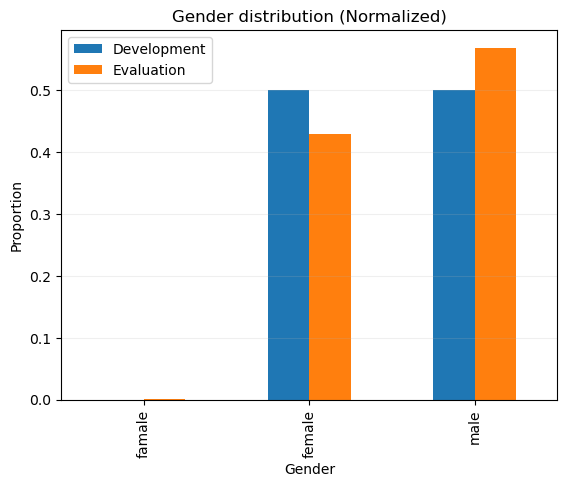

In [146]:
# Calculate the value counts for gender in both datasets
gender_dev_counts = df_dev["gender"].value_counts(normalize=True)
gender_eval_counts = df_eval["gender"].value_counts(normalize=True)

# Combine the counts into a single DataFrame
gender_counts = pd.DataFrame({
    'Development': gender_dev_counts,
    'Evaluation': gender_eval_counts
}).fillna(0)

# Plot the gender distribution
gender_counts.plot(kind='bar')
plt.title("Gender distribution (Normalized)")
plt.xlabel("Gender")
plt.ylabel("Proportion")
plt.legend()
plt.grid(alpha=0.2, axis="y")
plt.show()


In [147]:
# We encode the gender using dummy encoding
df_dev['gender'] = df_dev['gender'].map(gender)
df_eval['gender'] = df_eval['gender'].map(gender)

In [148]:
def extract_audio_features(dataset: str, index: int, n_mfcc: int = 13) -> dict:
    """
    Extracts the audio features from the given folder and index.
    """

    # Load the audio file
    audio_path = f'data/audios_{dataset}/{index+1}.wav'
    y, sr = librosa.load(audio_path, sr=None)

    # Extract the features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_d = librosa.feature.delta(mfcc)


    mfcc = np.percentile(mfcc, [5, 50, 95], axis=1) 
    mfcc_d = np.percentile(mfcc_d, [5, 50, 95], axis=1)

    d = {f"MFCC-{el+1}-5": mfcc[0][el] for el in range(n_mfcc)}
    d |= {f"MFCC-{el+1}-50": mfcc[1][el] for el in range(n_mfcc)}
    d |= {f"MFCC-{el+1}-95": mfcc[2][el] for el in range(n_mfcc)}
    d |= {f"MFCCD-{el+1}-5": mfcc_d[0][el] for el in range(n_mfcc)}
    d |= {f"MFCCD-{el+1}-50": mfcc_d[1][el] for el in range(n_mfcc)}
    d |= {f"MFCCD-{el+1}-95": mfcc_d[2][el] for el in range(n_mfcc)}

    features = {
        'Id': index,
        'duration': librosa.get_duration(y=y, sr=sr),
        'spectral_bandwidth': librosa.feature.spectral_bandwidth(y=y, sr=sr).mean(axis=1).item(),
        'spectral_rolloff': librosa.feature.spectral_rolloff(y=y, sr=sr).mean(axis=1).item(),
        'sampling_rate': sr,
        **d
    }
    
    return features


In [149]:
ll = []
for index in tqdm(df_dev.index):
    features = extract_audio_features('development', index)
    ll.append(features)
audio_dev = pd.DataFrame(ll).set_index('Id').sort_index()

ll = []
for index in tqdm(df_eval.index):
    features = extract_audio_features('evaluation', index)
    ll.append(features)
audio_eval = pd.DataFrame(ll).set_index('Id').sort_index()

  0%|          | 0/2933 [00:00<?, ?it/s]C:\Users\lucad\AppData\Local\Temp\ipykernel_35296\3555162648.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None)
c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 28%|██▊       | 811/2933 [02:52<07:31,  4.70it/s]


KeyboardInterrupt: 

In [9]:
df_dev = pd.concat([df_dev, audio_dev], axis=1)
df_eval = pd.concat([df_eval, audio_eval], axis=1)

Sampling rate distribution

In [ ]:

# Calculate the value counts for sampling_rate in both datasets
sampling_rate_dev_counts = df_dev["sampling_rate"].value_counts(normalize=True)
sampling_rate_eval_counts = df_eval["sampling_rate"].value_counts(normalize=True)

# Combine the counts into a single DataFrame
sampling_rate_counts = pd.DataFrame({
    'Development': sampling_rate_dev_counts,
    'Evaluation': sampling_rate_eval_counts
}).fillna(0)

# Plot the sampling rate distribution
sampling_rate_counts.plot(kind='bar')
plt.title("Sampling rate distribution (Normalized)")
plt.xlabel("Sampling Rate")
plt.ylabel("Proportion")
plt.legend()
plt.grid(alpha=0.2, axis="y")
plt.show()


KeyError: 'sampling_rate'

In [ ]:
df_dev.drop(columns=['sampling_rate'], inplace=True)
df_eval.drop(columns=['sampling_rate'], inplace=True)

Num words distribution

Text(0.5, 0, 'Number of words')

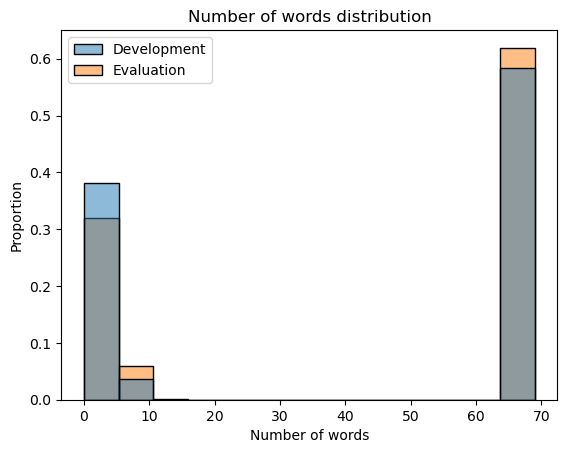

In [139]:
words = pd.DataFrame({
    'Development': df_dev["num_words"],
    'Evaluation': df_eval["num_words"]
})

sns.histplot(words, multiple="layer", stat="proportion", common_norm=False)
plt.title("Number of words distribution")
plt.xlabel("Number of words")    

In [13]:
df_dev['mean_silence'] = df_dev['silence_duration']/df_dev['num_pauses']
df_dev['silence_ratio'] = df_dev['silence_duration']/df_dev['duration']
df_dev['wps'] = df_dev['num_words']/df_dev['duration']

df_eval['mean_silence'] = df_eval['silence_duration']/df_eval['num_pauses']
df_eval['silence_ratio'] = df_eval['silence_duration']/df_eval['duration']
df_eval['wps'] = df_eval['num_words']/df_eval['duration']

In [15]:
df_dev.to_csv('data/development_processed.csv')
df_eval.to_csv('data/evaluation_processed.csv')